In [1]:
import numpy as np
import os
from scipy import fft
from matplotlib import pyplot as plt
import scipy.io

In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
os.chdir('/content/drive/MyDrive/Uni/ImageProcessing')

rootfolder = 'Colab Students - Assignments/data'

Generating 1-D DCT basis
------------------------


In [4]:
M = 128 # signal dimension
N = M # nr of atoms in the basis (this will be different when using redundant set of generators)

D = np.zeros((M, N)) # matrix containing the DCT basis (a DCT function in each column)
DCT = np.zeros((M, N)) # matrix containing the standard basis (a kronecker delta in each column)

C_zero = np.sqrt(1/M)
C_k = np.sqrt(2/M)       # for each k not 0

for k in range(M):
    # take the formula from slides and remember to normalize. Each atom goes in a column of DCT matrix
    DCT[:, k] = C_zero * np.ones(M) if k == 0 else C_k * np.cos(k*np.pi*(np.arange(M)+0.5)/M)
    DCT[:,k] = DCT[:,k] / np.linalg.norm(DCT[:,k])

DCT.shape

(128, 128)

Display an atom of the dct basis

Text(0.5, 1.0, 'element: 25 from the DCT basis')

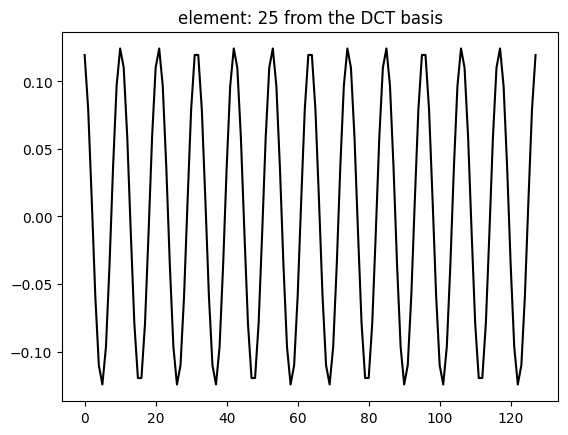

In [5]:
k = 24
plt.figure()
plt.plot(DCT[:, k], 'k')
plt.title(f'element: {k+1} from the DCT basis')

Check orthogonality

In [6]:
is_DCT_orth = True if np.allclose(np.matmul(DCT.T, DCT), np.eye(M)) else False
print(f'DCT dictionary is orthogonal: {is_DCT_orth}')

DCT dictionary is orthogonal: True


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

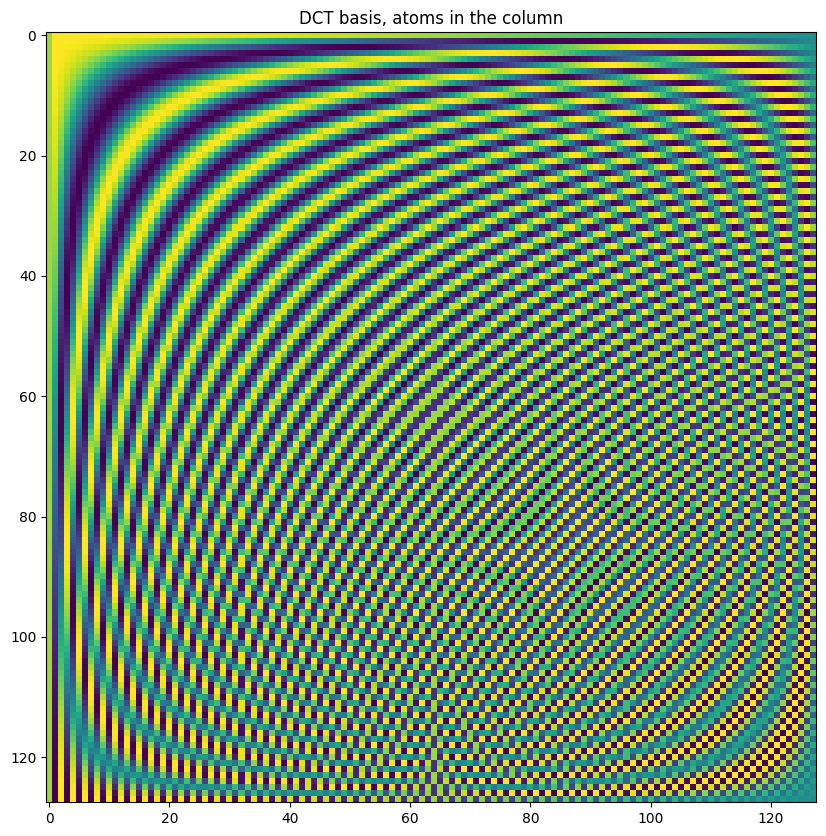

In [7]:
plt.figure(figsize=(10,10))
plt.imshow(DCT)
plt.title('DCT basis, atoms in the column')

Generate 1D DCT basis using the function idct
---------------------------------------------
idct is the inverse dct transform stack this in the matrix D

In [8]:
for k in range(M):
    # define the atom
    a = np.zeros(M)
    a[k] = 1
    D[:, k] = fft.idct(a, norm='ortho')


Display the basis in the matrix

Text(0.5, 1.0, 'DCT basis, atoms in the column')

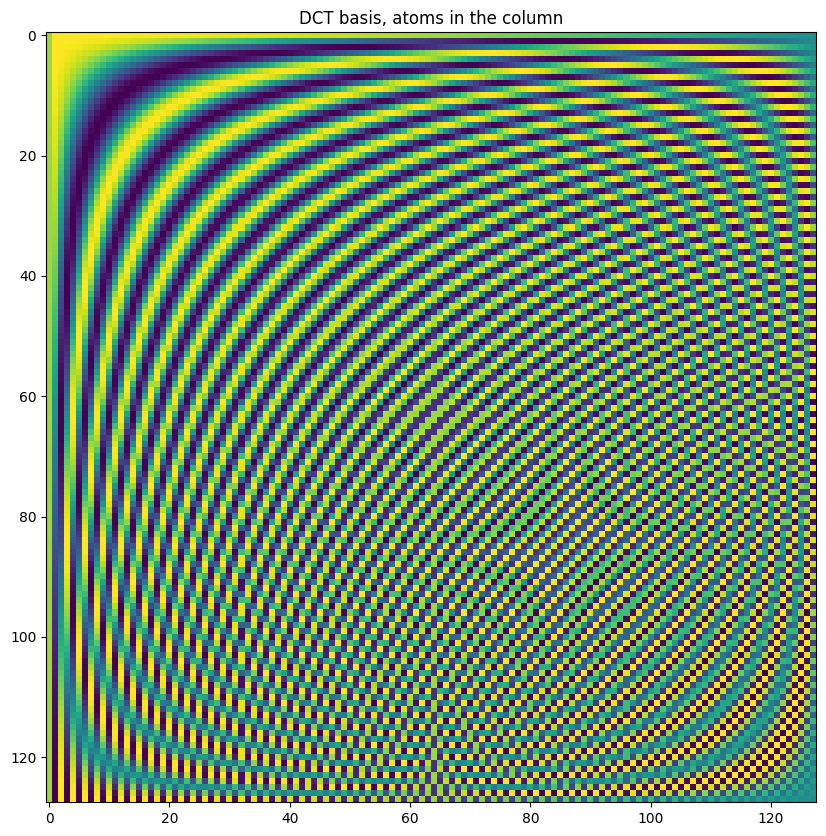

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(D)
plt.title('DCT basis, atoms in the column')

Check that D and DCT defined above coincide

In [10]:
is_DCT_equal_D = True if np.allclose(DCT, D) else False
print(f'D and DCT are equal: {is_DCT_equal_D}')

D and DCT are equal: True


Analysis: compute the representation of an input ECG signal
-----------------------------------------------------------
Load few ECG signals to be processed

In [11]:
temp = scipy.io.loadmat(f'{rootfolder}/croppedECG.mat')
nBeats = 10
S = temp['S'][:, :nBeats]
X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S.shape

(128, 10)

Compute the representation coefficients

In [12]:
for i in range(nBeats):
    X[:, i] = DCT.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

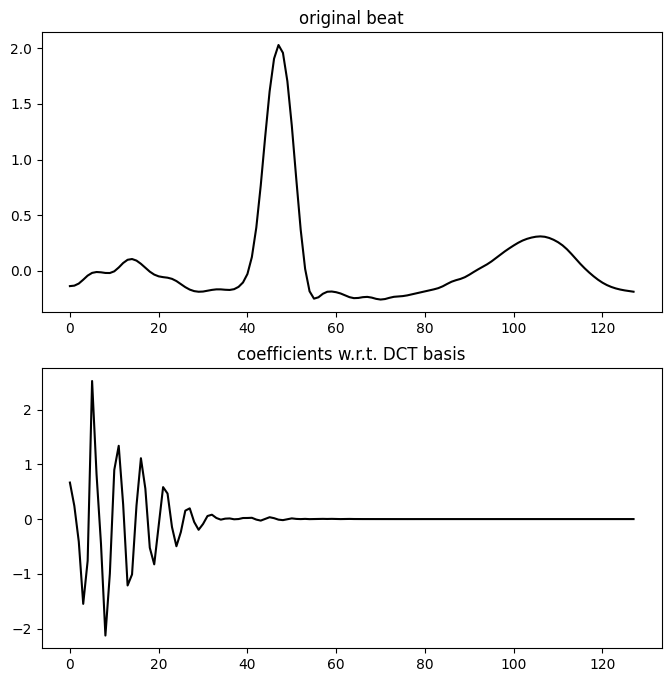

In [13]:
i = 5
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))
ax1.plot(S[:, i], 'k')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'k')
ax2.set_title('coefficients w.r.t. DCT basis')

Synthesis: reconstruct all the ECG signals from their representations
---------------------------------------------------------------------
Reconstruct the two signals (express them w.r.t. the standard basis)

In [14]:
S_hat_D = D @ X


Check if there is perfect reconstruction.

It is trivial because $\hat S_D = DD^TS$ and $DD^T = I_M$  since $D$ is orthonormal (the same applies to $C$)

In [15]:
is_reconstruction_perfect = True if np.allclose(S_hat_D, S) else False
print(f'The reconstruction is perfect: {is_reconstruction_perfect}')

The reconstruction is perfect: True


Add noise to ECG data and inspect the representations
-----------------------------------------------------


In [16]:
sigma_noise = 0.1
S0 = S.copy()
S = S0 + sigma_noise * np.random.normal(size=S0.shape)

X = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D


Compute the representation coefficients

In [17]:
for i in range(nBeats):
    X[:, i] = DCT.T @ S[:, i]

Display a signal and its representation coefficients

Text(0.5, 1.0, 'coefficients w.r.t. DCT basis')

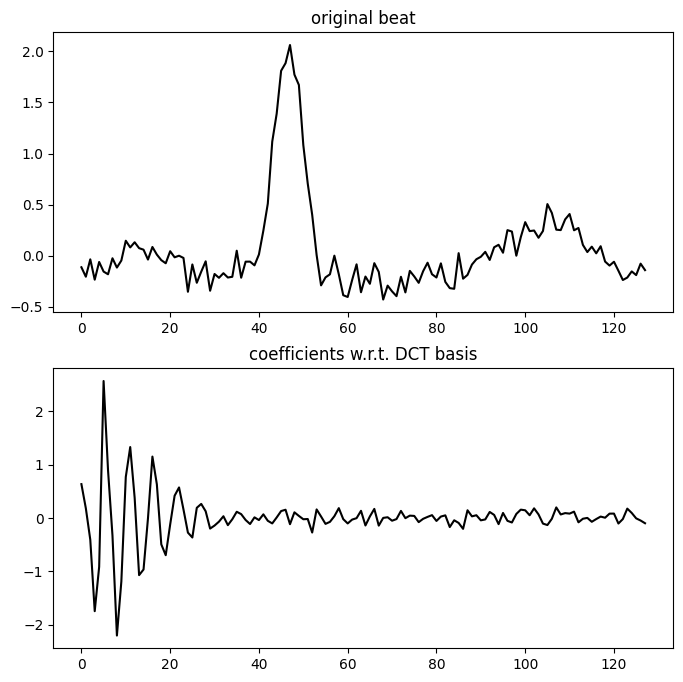

In [18]:
i = 3
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'k')
ax1.set_title('original beat')
ax2.plot(X[:, i], 'k')
ax2.set_title('coefficients w.r.t. DCT basis')

Hard Thresholding
-----------------
Noise affects all the coefficients of our transformation

Keep only $L$ coefficients having largest magnitude

In [24]:
X_HT = np.zeros((M, nBeats)) # initialize the matrix of representations of S w.r.t. D
S_hat = np.zeros((M, nBeats))
L = 21 # sparsity level (try different values)

for i in range(nBeats):
    origSignal =  S0[:, i]
    noisySignal = S[:, i]

    # transform each signal separately (analysis)
    x =  DCT.T @ noisySignal

    # keep only the L largest coefficients (absolute value)
    abs_x = np.abs(x)
    threshold = np.partition(abs_x, -L)[-L]
    mask = abs_x >= threshold
    x_sparse = np.zeros_like(x)
    x_sparse[mask] = x[mask]
    X_HT[:, i] = x_sparse

    # invert the transformation
    s_hat =  DCT @ X_HT[:, i]

    S_hat[:, i] = s_hat


Display a signal

Text(0.5, 1.0, 'DCT coefficients')

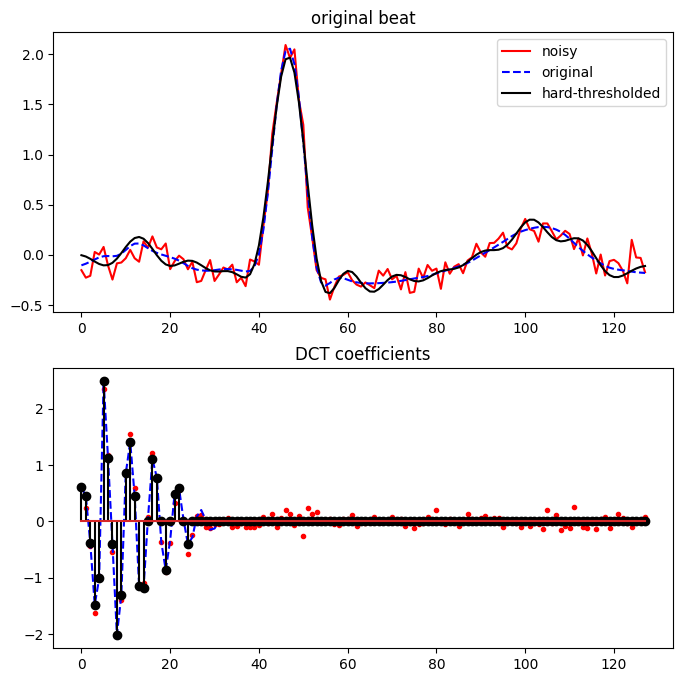

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,8))
ax1.plot(S[:, i], 'r')
ax1.plot(S0[:, i], 'b--')
ax1.plot(S_hat[:, i], 'k')
ax1.legend(['noisy', 'original', 'hard-thresholded'])
ax1.set_title('original beat')

# coefficients of the noisy signal
ax2.plot(np.matmul(D.T, S[:, i]), 'r.')
# coefficients of the noise free signal
ax2.plot(np.matmul(D.T, S0[:, i]), 'b--')
ax2.stem(np.arange(M), X_HT[:, i], 'k')
ax2.set_title('DCT coefficients')

Compression
-----------
Try to compress a heartbeat using different value of $L$ and plot the mean squared error corresponding to each $L$

In [21]:
import matplotlib.ticker as mtick

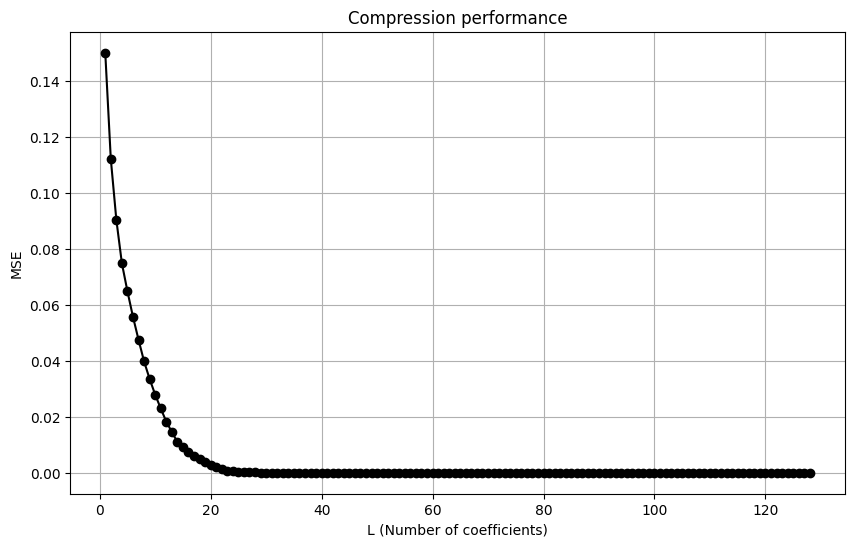

In [22]:
x_HT = np.zeros((M)) # initialize the matrix of representations of S w.r.t. D
s_hat = np.zeros((M))

L_values = np.arange(1, M+1)
MSE_values = np.zeros(M)
MSE_values_percent = np.zeros(M)

origSignal = S0[:, 3]

energy_orig = np.sum(origSignal**2)

for L in L_values:
     # transform each signal separately (analysis)
    x = DCT.T @ origSignal

    # keep only the L largest coefficients (absolute value)
    abs_x = np.abs(x)
    threshold = np.partition(abs_x, -L)[-L]
    mask = abs_x >= threshold
    x_sparse = np.zeros_like(x)
    x_sparse[mask] = x[mask]
    x_HT = x_sparse

    # invert the transformation
    s_hat = DCT @ x_HT[:]

    mse = np.mean((origSignal - s_hat)**2)

    MSE_values[L-1] = mse

    mse_percent = (np.sum((origSignal - s_hat)**2) / energy_orig) * 100
    MSE_values_percent[L-1] = mse_percent

plt.figure(figsize=(10,6))
plt.plot(L_values, MSE_values, '-o', color = 'black')
plt.xlabel('L (Number of coefficients)')
plt.ylabel('MSE')
plt.title('Compression performance')
# plt.ylim(0, 0.02)
plt.grid()

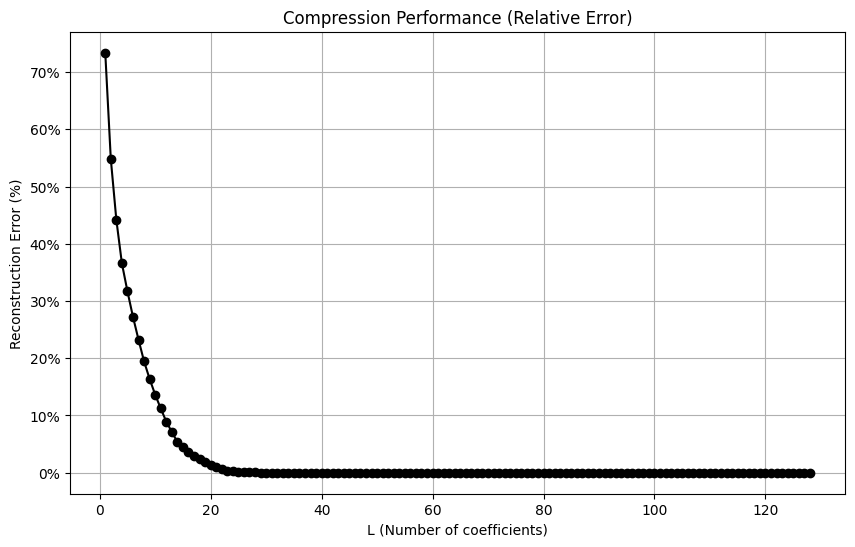

In [23]:
plt.figure(figsize=(10,6))
plt.plot(L_values, MSE_values_percent, '-o', color = 'black')
plt.xlabel('L (Number of coefficients)')
plt.ylabel('Reconstruction Error (%)')
plt.title('Compression Performance (Relative Error)')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.grid()